In [6]:
pip install ImageHash

  Using cached ImageHash-4.3.1-py2.py3-none-any.whl.metadata (8.0 kB)
Using cached ImageHash-4.3.1-py2.py3-none-any.whl (296 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 1.5 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [7]:
import datetime

start_time = datetime.datetime.now()

import pandas as pd
import numpy as np
import os
import torch
import imagehash
import glob
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from PIL import Image

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
cd '/Users/alexshienhowkhoo/Documents/NTU_BCG/NTU_BCG_Y3S1/Others/SC4000_Machine_Learning/SC4000_Project/SC4000_Machine_Learning/scripts'

/Users/alexshienhowkhoo/Documents/NTU_BCG/NTU_BCG_Y3S1/Others/SC4000_Machine_Learning/SC4000_Project/SC4000_Machine_Learning/scripts


/Users/alexshienhowkhoo/Library/Python/3.12/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [13]:
TRAIN_DIR = "../dataset/train_images/"
TRAIN_CSV_PATH = "../dataset/train.csv"

In [23]:
train_df = pd.read_csv(TRAIN_CSV_PATH)

In [4]:
funcs = [
    imagehash.average_hash,
    imagehash.phash,
    imagehash.dhash,
    imagehash.whash,
]
image_ids = []
hashes = []

for path in tqdm(glob.glob(TRAIN_DIR + "*.jpg")):
    image = Image.open(path)
    image_id = os.path.basename(path)
    image_ids.append(image_id)
    hashes.append(np.array([f(image).hash for f in funcs]).reshape(256))

hashes_all = np.array(hashes)

  0%|          | 0/27053 [00:00<?, ?it/s]

100%|██████████| 27053/27053 [12:17<00:00, 36.68it/s]


In [5]:
hashes_all = torch.Tensor(hashes_all.astype(int))

In [6]:
sims = np.array(
    [
        (hashes_all[i] == hashes_all).sum(dim=1).numpy() / 256
        for i in range(hashes_all.shape[0])
    ]
)

In [7]:
indices1 = np.where(sims > 0.9)
indices2 = np.where(indices1[0] != indices1[1])
image_ids1 = [image_ids[i] for i in indices1[0][indices2]]
image_ids2 = [image_ids[i] for i in indices1[1][indices2]]
dups = {
    tuple(sorted([image_id1, image_id2])): True
    for image_id1, image_id2 in zip(image_ids1, image_ids2)
}
print("found %d duplicates" % len(dups))

found 723 duplicates


[('1002088496.jpg', 'train-cbsd-614.jpg'), ('1024367055.jpg', 'train-cgm-677.jpg'), ('1046486747.jpg', 'train-cbsd-1272.jpg'), ('1050134400.jpg', 'train-cmd-1049.jpg'), ('1059986462.jpg', 'train-cgm-416.jpg'), ('1069816211.jpg', 'train-cgm-456.jpg'), ('1072259548.jpg', 'train-cbsd-355.jpg'), ('1080179563.jpg', 'train-cmd-10.jpg'), ('1080281713.jpg', 'train-cmd-1009.jpg'), ('1081937072.jpg', 'train-cmd-809.jpg'), ('1089661926.jpg', 'train-cbsd-1248.jpg'), ('1099882902.jpg', 'train-cbsd-50.jpg'), ('1102683272.jpg', 'train-cmd-2099.jpg'), ('1118493919.jpg', 'train-cmd-1643.jpg'), ('112557905.jpg', 'train-cmd-207.jpg'), ('1128747807.jpg', 'train-cmd-2601.jpg'), ('1133309905.jpg', 'train-cgm-714.jpg'), ('114251805.jpg', 'train-cgm-482.jpg'), ('1143548479.jpg', 'train-cmd-1456.jpg'), ('1144657211.jpg', 'train-cmd-646.jpg'), ('11690064.jpg', 'train-cbb-345.jpg'), ('1172621803.jpg', 'train-cmd-2371.jpg'), ('1180559828.jpg', 'train-cmd-986.jpg'), ('1194116552.jpg', 'train-cmd-2630.jpg'), ('1197

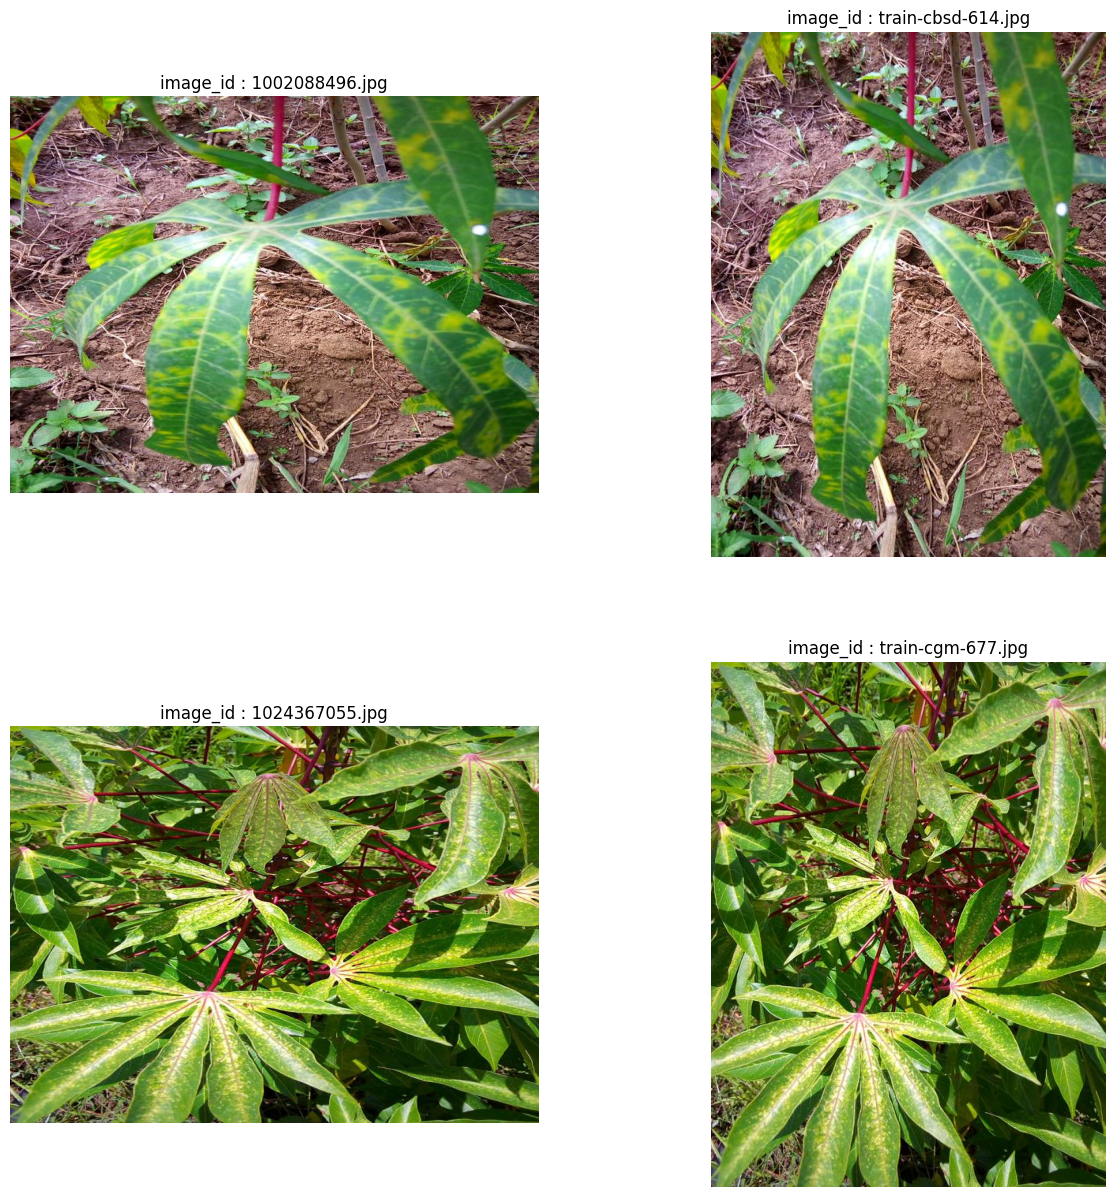

In [8]:
duplicate_image_ids = sorted(list(dups))
print(duplicate_image_ids)
fig, axs = plt.subplots(2, 2, figsize=(15,15))

for row in range(2):
    for col in range(2):
        img_id = duplicate_image_ids[row][col]
        img = Image.open(TRAIN_DIR + img_id)
        label =str(train_df.loc[train_df['image_id'] == img_id].labels.values[0])
        axs[row, col].imshow(img)
        axs[row, col].set_title("image_id : "+ img_id)
        axs[row, col].axis('off')

In [9]:
# Extracting the labels of duplicate images
duplicate_labels = []
for image_id1, image_id2 in duplicate_image_ids:
    label1 = train_df.loc[train_df["image_id"] == image_id1, "labels"].values[0]
    label2 = train_df.loc[train_df["image_id"] == image_id2, "labels"].values[0]
    duplicate_labels.extend([label1, label2])

# Create a pandas Series to get the label distribution
label_distribution = pd.Series(duplicate_labels).value_counts()
print(label_distribution)

3    709
1    313
2    277
0    125
4     22
Name: count, dtype: int64


In [12]:
# Helper function to check if the image ID (without extension) is numeric
def is_numeric_filename(image_id):
    return os.path.splitext(image_id)[0].isdigit()

image_ids_to_keep = set()
for image_id1, image_id2 in duplicate_image_ids:
    # Check if the first or second image ID is numeric
    if is_numeric_filename(image_id1) and not is_numeric_filename(image_id2):
        image_ids_to_keep.add(image_id1)  # Keep the numeric one
    elif is_numeric_filename(image_id2) and not is_numeric_filename(image_id1):
        image_ids_to_keep.add(image_id2)  # Keep the numeric one
    elif is_numeric_filename(image_id1) and is_numeric_filename(image_id2):
        image_ids_to_keep.add(image_id1)  # If both are numeric, just keep one


duplicate_image_ids_flat = set([img for pair in duplicate_image_ids for img in pair])

# Keep the numeric image IDs and filter out duplicates
train_df_filtered = train_df[
    ~train_df["image_id"].isin(duplicate_image_ids_flat)
    | train_df["image_id"].isin(image_ids_to_keep)
]

New CSV generated at: ../data/train_images_filtered_no_duplicates.csv


In [16]:
train_df_filtered = train_df
print(train_df_filtered)

             image_id  label
0      1000015157.jpg      0
1      1000201771.jpg      3
2       100042118.jpg      1
3      1000723321.jpg      1
4      1000812911.jpg      3
...               ...    ...
21392   999068805.jpg      3
21393   999329392.jpg      3
21394   999474432.jpg      1
21395   999616605.jpg      4
21396   999998473.jpg      4

[21397 rows x 2 columns]


In [18]:
unique_labels = train_df_filtered.label.value_counts()
num_unique_labels = unique_labels.nunique()
print(unique_labels)

label
3    13158
4     2577
2     2386
1     2189
0     1087
Name: count, dtype: int64


In [ ]:
from sklearn import model_selection

df_train, df_temp = model_selection.train_test_split(
    train_df_filtered, test_size=0.4, random_state=109, stratify=train_df_filtered["label"].values
)

df_valid, df_test = model_selection.train_test_split(
    df_temp, test_size=0.5, random_state=109, stratify=df_temp["label"].values
)

In [19]:
from imblearn.over_sampling import SMOTE

# Set SMOTE to balance all classes to the size of the largest class
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [4]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from skimage.io import imread
import os
# Step 1: Load Images
image_paths = "../dataset/train_images/"  

smote_output_folder = "../dataset/smote_images/"   
os.makedirs(smote_output_folder, exist_ok=True)

X = []
y = []

for idx, row in train_df.iterrows():
    image_id = row['image_id']
    label = row['label']
    
    # Load each image, assuming file path format is image_paths + image_id + '.jpg'
    image = imread(f"{image_paths}{image_id}")
    
    # Append image and label
    X.append(image)
    y.append(label)

X = np.array(X)  # Convert to numpy array
y = np.array(y)

OSError: [Errno 30] Read-only file system: '../dataset'

In [ ]:

# Step 2: Flatten images if necessary
X_flattened = X.reshape(X.shape[0], -1)  # Flatten to 1D if needed

# Step 3: Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled_flattened, y_resampled = smote.fit_resample(X_flattened, y)

# Step 4: Reshape back if you flattened
image_shape = X.shape[1:]  # Original shape
X_resampled = X_resampled_flattened.reshape(-1, *image_shape)

# Step 5: Create DataFrame with resampled data
# Optionally, create synthetic `image_id`s for new samples or add a prefix to differentiate
df_resampled = pd.DataFrame({
    'image_id': [f"{i}_synthetic" for i in range(len(y_resampled))],  # New synthetic IDs
    'class_label': y_resampled
})

# Save SMOTE-generated images
for i, img_array in enumerate(X_resampled[len(X):]):  # Only new images
    img = Image.fromarray(img_array.astype('uint8'), 'RGB')  # Convert numpy array to Image
    img.save(f"{smote_output_folder}/smote_image_{i}.jpg")  # Save with unique name




In [11]:
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler

# desired_majority_class_size = 6000

# class_counts = df_train["labels"].value_counts()
# undersample_strategy = {class_counts.idxmax(): desired_majority_class_size}

# rus = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=109)
# X_under, y_under = rus.fit_resample(
#     df_train["image_id"].values.reshape(-1, 1), df_train["labels"].values
# )

# desired_minority_class_size = 6000

# ros = RandomOverSampler(
#     sampling_strategy={
#         label: desired_minority_class_size
#         for label in class_counts.index
#         if class_counts[label] < desired_minority_class_size
#     },
#     random_state=109,
# )
# X_resampled, y_resampled = ros.fit_resample(X_under, y_under)

# df_train_resampled = pd.DataFrame(
#     {"image_id": X_resampled.flatten(), "labels": y_resampled}
# )

# # Check the new class distribution
# print(df_train_resampled["labels"].value_counts())

# df_train_resampled.reset_index(drop=True, inplace=True)


0:14:42.564073


In [ ]:
output_csv_path = "../data/train_images_filtered_no_duplicates.csv"
train_df_filtered.to_csv(output_csv_path, index=False)

print(f"New CSV generated at: {output_csv_path}")

end_time = datetime.datetime.now()
print(end_time - start_time)
